In [ ]:
!pip install torchxrayvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 39.9 MB/s eta 0:00:00


In [ ]:
import os,sys
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import sys
import torch.nn.functional as F
import tqdm
import sklearn, sklearn.metrics
import pandas as pd
import torchxrayvision as xrv
from google.colab import drive
import skimage
from PIL import Image

In [ ]:
drive.mount('/content/drive')
datapath = 'drive/MyDrive/data/NIH-sample/'
images_path = 'images-224'

Mounted at /content/drive


In [ ]:
d_nih = xrv.datasets.NIH_Dataset(imgpath=datapath+images_path)

In [ ]:
xrv.datasets.relabel_dataset(xrv.datasets.default_pathologies, d_nih)

Lung Lesion doesn't exist. Adding nans instead.
Fracture doesn't exist. Adding nans instead.
Lung Opacity doesn't exist. Adding nans instead.
Enlarged Cardiomediastinum doesn't exist. Adding nans instead.


In [ ]:
model = xrv.models.DenseNet(weights="densenet121-res224-all")

If this fails you can run `wget https://github.com/mlmed/torchxrayvision/releases/download/v1/nih-pc-chex-mimic_ch-google-openi-kaggle-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt -O /root/.torchxrayvision/models_data/nih-pc-chex-mimic_ch-google-openi-kaggle-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt`
[██████████████████████████████████████████████████]


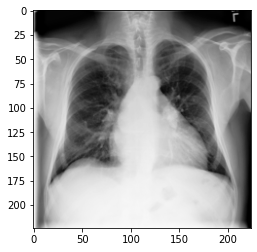

In [ ]:
sample = d_nih[0]
plt.imshow(sample["img"][0], cmap="Greys_r");

In [ ]:
img = skimage.io.imread(datapath+images_path+"/00000001_002.png")
print(img.shape)

(224, 224)


In [ ]:
print(img)

[[ 15  13  11 ...  23  24  24]
 [ 16  13  11 ...  22  23  23]
 [ 15  13  11 ...  20  21  21]
 ...
 [ 19  17  16 ... 101  69  30]
 [ 20  18  17 ... 104  73  31]
 [ 23  20  18 ...  97  69  30]]


In [ ]:
img = xrv.datasets.normalize(img, 255) # convert 8-bit image to [-1024, 1024] range
transform = torchvision.transforms.Compose([xrv.datasets.XRayResizer(224)])
img = transform(img)
img = torch.from_numpy(img)
outputs = model(img[None,...])

In [ ]:
dict(zip(model.pathologies,outputs[0].detach().numpy()))

{'Atelectasis': 0.571203,
 'Consolidation': 0.52688956,
 'Infiltration': 0.44442007,
 'Pneumothorax': 0.5100217,
 'Edema': 0.5184275,
 'Emphysema': 0.51508546,
 'Fibrosis': 0.5001646,
 'Effusion': 0.5407455,
 'Pneumonia': 0.62831914,
 'Pleural_Thickening': 0.5194574,
 'Cardiomegaly': 0.52360696,
 'Nodule': 0.5051501,
 'Mass': 0.522989,
 'Hernia': 0.13940573,
 'Lung Lesion': 0.0497013,
 'Fracture': 0.5006705,
 'Lung Opacity': 0.64618814,
 'Enlarged Cardiomediastinum': 0.55249053}

In [ ]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 KB 13.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283859 sha256=37180434d0f4f52fbce2bd78621bea3b98bfde4aeabc356dd7fa86e7a5be3f0c
  Stored in directory: /root/.cache/pip/wheels/ed/d7/c9/5a0130d06d6310bc6cbe55220e6e72dcb8c4eff9a478717066
Successfully built lime


In [ ]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [ ]:
def image_predict(imgs):
  # img = np.array(img).transpose(2,0,1)
  pred_list = []
  for img in imgs:
    print(img.shape)
    img_PIL = Image.fromarray(img).convert('RGB')
    print("???", np.array(img_PIL).shape)
    img = img_PIL.convert('L')
    img = np.array(img)
    print(img)

    img = xrv.datasets.normalize(img, 255) # convert 8-bit image to [-1024, 1024] range
    transform = torchvision.transforms.Compose([xrv.datasets.XRayResizer(224)])
    img = transform(img)
    img = torch.from_numpy(img)
    outputs = model(img[None,...])
    output_mean = outputs.mean(0).detach().cpu().numpy()
    pred_list.append(output_mean)
  numpy_probs = np.stack(pred_list, axis=0)
  # res = output_mean[0].detach().numpy()
  return numpy_probs

In [ ]:
# def explain_instance(img, img_diseases = None, num_samples = 5):
#     """
#     Args:
#         img: the original 3-dimensional numpy array before transforming into torch tensor
#         img_diseases: string of diseases for the image
#         num_samples: 5 (the number of neighbours to consider)
    
#     Global Variables:
#         explainer: pre-defined explainer object
#     """
#     explanation = explainer.explain_instance(img,
#                                              batch_image_predict,
#                                              top_labels=5, 
#                                              num_samples=num_samples)
#     temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
#                                                 positive_only=False, 
#                                                 num_features=10, 
#                                                 hide_rest=False)
#     print(temp.shape)
#     print(mask.shape)
#     img_boundry2 = mark_boundaries(temp, mask)
#     plt.imshow(img_boundry2)

#     if img_diseases is not None:
#         plt.title(f"Diseases: {img_diseases}")
        
#     return

In [ ]:
img_ids = datapath+images_path+"/00000001_002.png"

In [ ]:
# img = Image.open(img_ids).convert('RGB').convert('L')
# img_np = np.array(img)
# print(img_np.shape)

(224, 224)


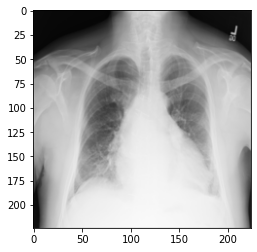

In [ ]:
img = Image.open(img_ids).convert('RGB')
img_np = np.array(img)
plt.imshow(img_np)

In [ ]:
print(img_np)

[[[ 15  15  15]
  [ 13  13  13]
  [ 11  11  11]
  ...
  [ 23  23  23]
  [ 24  24  24]
  [ 24  24  24]]

 [[ 16  16  16]
  [ 13  13  13]
  [ 11  11  11]
  ...
  [ 22  22  22]
  [ 23  23  23]
  [ 23  23  23]]

 [[ 15  15  15]
  [ 13  13  13]
  [ 11  11  11]
  ...
  [ 20  20  20]
  [ 21  21  21]
  [ 21  21  21]]

 ...

 [[ 19  19  19]
  [ 17  17  17]
  [ 16  16  16]
  ...
  [101 101 101]
  [ 69  69  69]
  [ 30  30  30]]

 [[ 20  20  20]
  [ 18  18  18]
  [ 17  17  17]
  ...
  [104 104 104]
  [ 73  73  73]
  [ 31  31  31]]

 [[ 23  23  23]
  [ 20  20  20]
  [ 18  18  18]
  ...
  [ 97  97  97]
  [ 69  69  69]
  [ 30  30  30]]]


In [ ]:
print(img_np.shape)

(224, 224, 3)


(224, 224, 3)


  0%|          | 0/100 [00:00<?, ?it/s]

(224, 224, 3)
??? (224, 224, 3)
[[ 15  13  11 ...  23  24  24]
 [ 16  13  11 ...  22  23  23]
 [ 15  13  11 ...  20  21  21]
 ...
 [ 19  17  16 ... 101  69  30]
 [ 20  18  17 ... 104  73  31]
 [ 23  20  18 ...  97  69  30]]
(224, 224, 3)
??? (224, 224, 3)
[[ 13  13  13 ...  23  24  24]
 [ 13  13  13 ...  22  23  23]
 [ 13  13  13 ...  20  21  21]
 ...
 [ 19  17  16 ... 196 196 196]
 [ 20  18  17 ... 196 196 196]
 [ 23  20  18 ... 196 196 196]]
(224, 224, 3)
??? (224, 224, 3)
[[ 13  13  13 ...  23  24  24]
 [ 13  13  13 ...  22  23  23]
 [ 13  13  13 ...  20  21  21]
 ...
 [168 168 168 ... 101  69  30]
 [168 168 168 ... 104  73  31]
 [168 168 168 ...  97  69  30]]
(224, 224, 3)
??? (224, 224, 3)
[[ 13  13  13 ...  23  24  24]
 [ 13  13  13 ...  22  23  23]
 [ 13  13  13 ...  20  21  21]
 ...
 [ 19  17  16 ... 196 196 196]
 [ 20  18  17 ... 196 196 196]
 [ 23  20  18 ... 196 196 196]]
(224, 224, 3)
??? (224, 224, 3)
[[ 15  13  11 ...  23  24  24]
 [ 16  13  11 ...  22  23  23]
 [ 15  13 

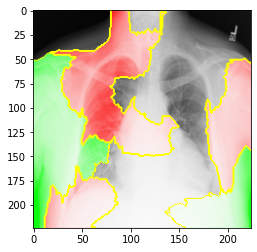

In [ ]:
img = img_np
img_diseases = None
num_samples = 100
print(img_np.shape)

explanation = explainer.explain_instance(img, image_predict,
                                             top_labels=5, 
                                             num_samples=num_samples)
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                                positive_only=False, 
                                                num_features=10, 
                                                hide_rest=False)
print(temp.shape)
print(mask.shape)
img_boundry2 = mark_boundaries(temp, mask)
plt.imshow(img_boundry2)

if img_diseases is not None:
  plt.title(f"Diseases: {img_diseases}")